In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Setup of an AI model 

1. Dataloader 
Code to load in your data in a format that your model expects it

2. Model Architecture 
Workhorse code that is actually doing the computation and 

3. Training Loop 
Code to train your model and 

4. Eval/Inference Loop 
Need to assess the effectiveness of your model before you use it in the real world!

Inference loop to see the results of the model on unseen data.

In [2]:
from torchvision import datasets
import os

# Download MNIST dataset
data_dir = os.path.join(os.getcwd(), 'mnist_data')
os.makedirs(data_dir, exist_ok=True)

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 392kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 31.8MB/s]

Training samples: 60000
Test samples: 10000


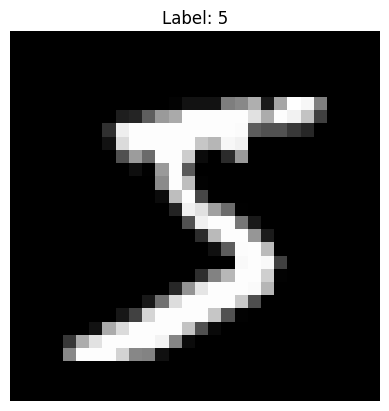

Image shape: (28, 28)


In [3]:
# Visualize MNIST sample
from torchvision import datasets

mnist_data = datasets.MNIST(root='mnist_data', train=True, download=True)
sample_img, sample_label = mnist_data[0]

plt.imshow(sample_img, cmap='gray')
plt.title(f'Label: {sample_label}')
plt.axis('off')
plt.show()

print(f"Image shape: {np.array(sample_img).shape}")

In [4]:
# Dataloader for MNIST

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

def create_mnist_dataloader(data_dir, train=True, batch_size=64, shuffle=True):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])
    
    dataset = datasets.MNIST(root=data_dir, train=train, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [5]:
# Simple Neural Network Model for MNIST

class SimpleCNNModel(nn.Module): 
    def __init__(self, input_channels, num_classes): 
        super(SimpleCNNModel, self).__init__() 
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After 2 pooling: 28x28 -> 14x14 -> 7x7
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

In [6]:
# training loop 
# IMPORTANT set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader: # unpack batched data from dataloader
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the parameter gradients

            outputs = model(inputs) # forward pass of data through model

            loss = criterion(outputs, labels) # calculate difference between model output and expected ouptut 

            loss.backward() # propogate the loss backward through the model

            optimizer.step() # update model parameters based on gradients

            running_loss += loss.item() * inputs.size(0) # update running loss

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [7]:
data_dir = os.path.join(os.getcwd(), 'mnist_data')

model = SimpleCNNModel(input_channels=1, num_classes=10)  # MNIST is grayscale (1 channel), 10 digits
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataloader = create_mnist_dataloader(data_dir, train=True, batch_size=64, shuffle=True)

train_model(model, train_dataloader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.1749
Epoch 2/5, Loss: 0.0597
Epoch 3/5, Loss: 0.0431
Epoch 4/5, Loss: 0.0334
Epoch 5/5, Loss: 0.0266


In [8]:
# eval/inference loop 

def evaluate_model(model, dataloader):
    model.eval() # put the model in evaluation mode so that it is not calculating gradients
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

In [9]:
test_dataloader = create_mnist_dataloader(data_dir, train=False, batch_size=64, shuffle=False)
evaluate_model(model, test_dataloader)

Accuracy: 99.30%


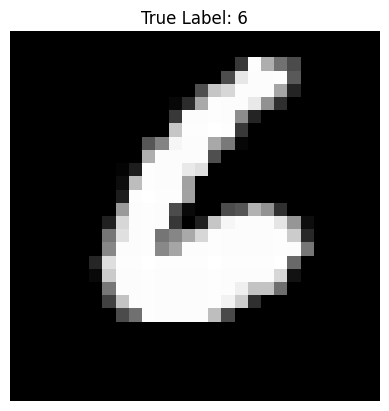

Predicted: 6, True: 6


In [10]:
# Test on a random MNIST image
test_data = datasets.MNIST(root='mnist_data', train=False, download=True)
idx = np.random.randint(len(test_data))
test_img, true_label = test_data[idx]

plt.imshow(test_img, cmap='gray')
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()

model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
img_tensor = transform(test_img).unsqueeze(0).to(device)
output = model(img_tensor)
_, predicted_class = torch.max(output, 1)

print(f'Predicted: {predicted_class.item()}, True: {true_label}')

Useful papers: https://github.com/awesomelistsio/awesome-ai-research-papers

Personal Favourites: 
Reinforcement learning on atari games: https://www.nature.com/articles/nature14236
Accurate protein folding: https://www.nature.com/articles/s41586-021-03819-2
Grokking: http://arxiv.org/abs/2201.02177
Image generation with latent diffusion: http://arxiv.org/abs/2112.10752
Intro to graphs: https://distill.pub/2021/gnn-intro/
